In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.semi_supervised import SelfTrainingClassifier
import numpy as np

In [111]:
df=pd.read_csv('../csv/dataset_ml.csv')

In [112]:
df=df.drop(['id_advert','city'],axis=1)
df['scam'] = df['scam'].replace({0:'No scam', 1:'Scam'})

In [113]:
# Séparer les variables indépendantes (X) de la variable cible (y)
X = df.drop("scam", axis=1)
y = df["scam"]

In [114]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [115]:
rng = np.random.RandomState(42)
pourcentage_non_labelisé = 0.8
random_unlabeled_points = rng.rand(y_train.shape[0]) < pourcentage_non_labelisé

In [116]:
# Garder en mémoire les indices des échantillons labellisés et les remplacer par -1
labeled_indices = np.where(~random_unlabeled_points)[0]
unlabeled_indices = np.where(random_unlabeled_points)[0]

In [117]:
# Remplacer les étiquettes des échantillons unlabelisés 
y_train.iloc[unlabeled_indices] = -1

In [118]:
# Définir les colonnes nécessitant une normalisation
numerical_cols = ['size','other_campus_dressing','other_campus_sell','hype_products_dressing',
                 'hype_products_sell','item_count','total_items_count','given_item_count','taken_item_count',
                 'feedback_reputation','followers_count','following_count']
binary_categorical_cols = ['price_decimal','ressell_price','promoted','identic_title_description','short_description',
                      'secure_description','has_emoji_description','description_user','sell_sneaker_account','photo',
                      'is_publish_photos_agreed','expose_location','verification_facebook','verification_google','verification_phone'] 
other_categorical_cols = ['gender','brand','country_title','modele']

## Semi-Supervised Learning: SelfTrainingClassifier()

In [119]:
# Définir les transformations pour les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normaliser les variables numériques
        ('bin_cat', 'passthrough', binary_categorical_cols),  # Ne rien faire pour les colonnes binaires
        ('other_cat', OneHotEncoder(handle_unknown='ignore'), other_categorical_cols)  # Appliquer OneHotEncoder aux autres colonnes catégorielles
    ])

In [120]:
# Créer le pipeline avec le préprocesseur et le modèle RandomForest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [121]:
# Entraîner le modèle
labeled_indices = np.array(labeled_indices)
pipeline.fit(X_train.iloc[labeled_indices], y_train.iloc[labeled_indices])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['size',
                                                   'other_campus_dressing',
                                                   'other_campus_sell',
                                                   'hype_products_dressing',
                                                   'hype_products_sell',
                                                   'item_count',
                                                   'total_items_count',
                                                   'given_item_count',
                                                   'taken_item_count',
                                                   'feedback_reputation',
                                                   'followers_count',
                                                   'following_count']),
                                                 ('bin_cat', 'passthrough',
                                                  ['price_...
                                                   'secure_description',
                                                   'has_emoji_description',
                                                   'description_user',
                                                   'sell_sneaker_account',
                                                   'photo',
                                                   'is_publish_photos_agreed',
                                                   'expose_location',
                                                   'verification_facebook',
                                                   'verification_google',
                                                   'verification_phone']),
                                                 ('other_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'brand',
                                                   'country_title',
                                                   'modele'])])),
                ('classifier', RandomForestClassifier())])

In [122]:
# Prédire sur l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train.iloc[labeled_indices])

# Prédire sur l'ensemble de test
y_test_pred = pipeline.predict(X_test)

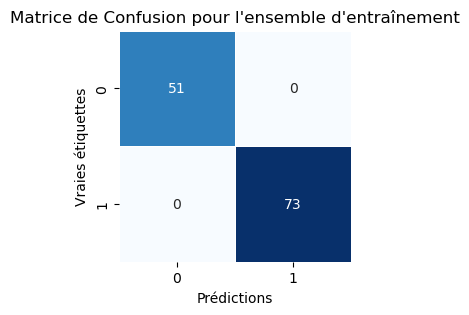

In [123]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_train.iloc[labeled_indices], y_train_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble d\'entraînement')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [124]:
# Afficher les métriques de classification pour l'ensemble d'entraînement
print("Métriques pour l'ensemble d'entraînement:")
print(classification_report(y_train.iloc[labeled_indices], y_train_pred))

Métriques pour l'ensemble d'entraînement:
              precision    recall  f1-score   support

     No scam       1.00      1.00      1.00        51
        Scam       1.00      1.00      1.00        73

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124



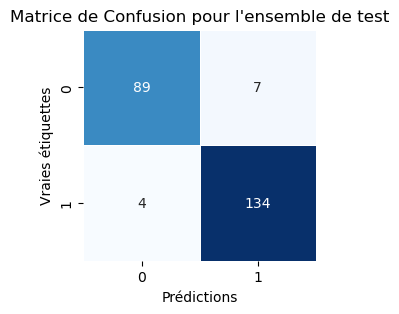

In [125]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [126]:
# Afficher les métriques de classification pour l'ensemble de test
print("Métriques pour l'ensemble de test:")
print(classification_report(y_test, y_test_pred))

Métriques pour l'ensemble de test:
              precision    recall  f1-score   support

     No scam       0.96      0.93      0.94        96
        Scam       0.95      0.97      0.96       138

    accuracy                           0.95       234
   macro avg       0.95      0.95      0.95       234
weighted avg       0.95      0.95      0.95       234



In [127]:
# ligne avec des erreurs
incorrect_predictions = X_test[y_test != y_test_pred]
incorrect_predictions

,modele,size,brand,price,price_decimal,ressell_price,promoted,identic_title_description,short_description,secure_description,...,followers_count,following_count,gender,photo,is_publish_photos_agreed,expose_location,country_title,verification_facebook,verification_google,verification_phone
149,brown,38.0,adidas,120.00,0,121,0,0,0,0,...,2,1,F,1,1,0,Frankreich,1,0,1
610,grey,38.5,adidas,150.00,0,143,1,0,0,0,...,0,0,not_specified,1,0,1,France,0,1,1
124,black,38.0,adidas Originals,100.00,0,118,0,0,0,0,...,3,0,not_specified,1,0,1,France,0,0,1
536,black,43.0,adidas,130.00,0,110,0,0,0,1,...,0,0,M,1,0,1,Francia,1,0,0
710,black,39.0,adidas,145.00,0,129,0,0,0,0,...,0,2,F,1,0,1,Belgique,0,0,1
517,grey,42.0,adidas,130.00,0,271,0,0,1,0,...,1,0,M,0,0,1,France,1,0,1
384,grey,37.5,adidas,139.99,0,216,0,0,0,1,...,1,3,M,1,0,1,France,0,0,1
164,black,37.0,adidas,100.77,1,111,0,0,1,0,...,3,1,F,1,0,1,France,0,0,1
616,black,38.0,adidas,135.00,0,118,0,0,0,1,...,0,0,M,1,0,1,Frankreich,0,0,1
611,grey,44.0,adidas,115.00,0,266,0,1,1,0,...,0,0,not_specified,1,0,0,France,0,1,0


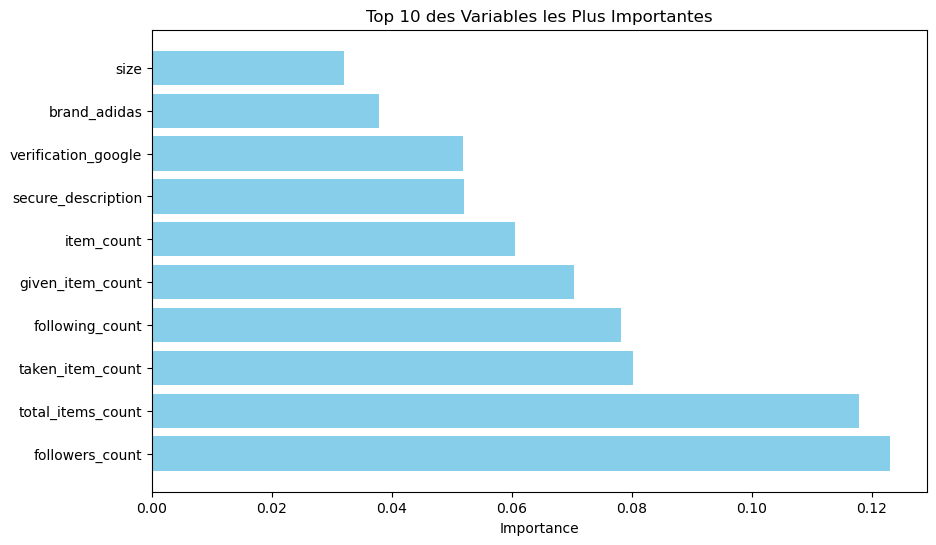

In [128]:
# Accéder à l'importance des variables
rf_model = pipeline.named_steps['classifier']
importances = rf_model.feature_importances_
preprocessed_columns = numerical_cols + binary_categorical_cols + list(pipeline.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out(other_categorical_cols))

feature_importances = pd.DataFrame({'Variable': preprocessed_columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Variable'][:10], feature_importances['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 des Variables les Plus Importantes')
plt.show()

## Semi-Supervised Learning: SelfTrainingClassifier()

In [129]:
# Créer le pipeline avec le préprocesseur et le selfTrainingClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SelfTrainingClassifier(RandomForestClassifier(),threshold=0.99))
])

In [130]:
# Entraîner le modèle
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['size',
                                                   'other_campus_dressing',
                                                   'other_campus_sell',
                                                   'hype_products_dressing',
                                                   'hype_products_sell',
                                                   'item_count',
                                                   'total_items_count',
                                                   'given_item_count',
                                                   'taken_item_count',
                                                   'feedback_reputation',
                                                   'followers_count',
                                                   'following_count']),
                                                 ('bin_cat', 'passthrough',
                                                  ['price_...
                                                   'description_user',
                                                   'sell_sneaker_account',
                                                   'photo',
                                                   'is_publish_photos_agreed',
                                                   'expose_location',
                                                   'verification_facebook',
                                                   'verification_google',
                                                   'verification_phone']),
                                                 ('other_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'brand',
                                                   'country_title',
                                                   'modele'])])),
                ('classifier',
                 SelfTrainingClassifier(base_estimator=RandomForestClassifier(),
                                        threshold=0.99))])

In [131]:
# Prédire sur l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train)

# Prédire sur l'ensemble de test
y_test_pred = pipeline.predict(X_test)

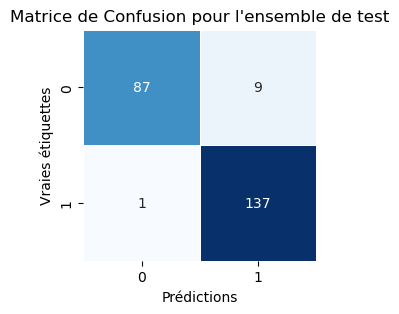

In [132]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [133]:
# Afficher les métriques de classification pour l'ensemble de test
print("Métriques pour l'ensemble de test:")
print(classification_report(y_test, y_test_pred))

Métriques pour l'ensemble de test:
              precision    recall  f1-score   support

     No scam       0.99      0.91      0.95        96
        Scam       0.94      0.99      0.96       138

    accuracy                           0.96       234
   macro avg       0.96      0.95      0.96       234
weighted avg       0.96      0.96      0.96       234



In [134]:
# ligne avec des erreurs
incorrect_predictions = X_test[y_test != y_test_pred]
incorrect_predictions

,modele,size,brand,price,price_decimal,ressell_price,promoted,identic_title_description,short_description,secure_description,...,followers_count,following_count,gender,photo,is_publish_photos_agreed,expose_location,country_title,verification_facebook,verification_google,verification_phone
149,brown,38.0,adidas,120.00,0,121,0,0,0,0,...,2,1,F,1,1,0,Frankreich,1,0,1
610,grey,38.5,adidas,150.00,0,143,1,0,0,0,...,0,0,not_specified,1,0,1,France,0,1,1
677,black,38.5,adidas,150.00,0,185,0,0,0,0,...,2,3,M,1,0,1,France,0,1,1
718,grey,38.5,adidas,155.00,0,143,0,0,0,0,...,1,1,F,1,0,0,France,0,0,1
536,black,43.0,adidas,130.00,0,110,0,0,0,1,...,0,0,M,1,0,1,Francia,1,0,0
710,black,39.0,adidas,145.00,0,129,0,0,0,0,...,0,2,F,1,0,1,Belgique,0,0,1
517,grey,42.0,adidas,130.00,0,271,0,0,1,0,...,1,0,M,0,0,1,France,1,0,1
164,black,37.0,adidas,100.77,1,111,0,0,1,0,...,3,1,F,1,0,1,France,0,0,1
616,black,38.0,adidas,135.00,0,118,0,0,0,1,...,0,0,M,1,0,1,Frankreich,0,0,1
341,black,41.0,Campus,130.00,0,110,0,0,0,1,...,0,0,not_specified,1,0,1,France,0,1,0
